Following runs on results_nodeterm

In [13]:
# Parse results

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as it
import re
from pathlib import Path

def mean(l):
    return sum(l) / len(l)

def parse_baseline_res(fpath):
    header = re.compile(r'--> Test (\S+) <--')
    time = re.compile(r'Time:\s*(.*)')
    
    with open(fpath, 'r') as f:
        lines = list(f.readlines())
        
    run_results = [lines[i::2] for i in range(2)]
    compiler = [(header, str), (time, float)]
    full_results = [[compiler[i][1](compiler[i][0].match(elems).group(1)) \
                         for elems in run_key] for i, run_key in enumerate(run_results)]
    full_results[0] = [Path(x).name.split('.')[0] for x in full_results[0]]
    baseline_dict = dict(zip(*full_results))
    print(baseline_dict)
    return baseline_dict
        

    
def parse_batch_res(lines):
    header = re.compile(r'<-- Batch: (\S+) -->')
    max_time = re.compile(r'Max Time:\s*(.*)')
    accuracy = re.compile(r'Accuracy:\s*(.*)')
    
    run_results = [lines[i::3] for i in range(3)]

    compiler = [(header, str), (max_time, float), (accuracy, float)]
    full_results = [[compiler[i][1](compiler[i][0].match(elems).group(1)) \
                         for elems in run_key] for i, run_key in enumerate(run_results)]
    
    test_names = sorted(list(set(full_results[0])))
    num_tests = len(test_names)
    
    comp_results = [full_results[0][:num_tests]] + \
                    [[mean(full_results[j][i::num_tests]) for i in range(num_tests)] for j in [1,2]]
   
    #comp_results_perc = [ [full_results[0][:num_tests]], \
    #                [mean(full_results[1][i::num_tests]) for i in range(num_tests)], \
    #                [mean(full_results[2][i::num_tests]) for i in range(num_tests)]
    #                    ]
    
    run_dict = { i[0]: i[1:] for i in zip(*comp_results) }
    return run_dict

    
    
results_dir = Path('results_nodeterm')

stoch_range = np.arange(10, 100, 10)
batch_range = np.arange(2, 12, 2)

dataset_paths = results_dir.glob('run_*.res')
baseline_path = results_dir / 'single_run.res'
noinst_path = results_dir / 'noinst_run.res'
baseline_dict = parse_baseline_res(baseline_path)
noinst_dict = parse_baseline_res(noinst_path)
testname_size = len(baseline_dict)

complete_run_dict = {}

for stoch, batch_size in it.product(stoch_range, batch_range):
    stoch_idx = np.where(stoch_range == stoch)[0][0]
    batch_idx = np.where(batch_range == batch_size)[0][0]
    #print(stoch, batch_size)
    
    runs_content = []
    for dpath in results_dir.glob(f"run_*_{stoch}_{batch_size}.res"):
        with open(dpath) as f:
            runs_content += list(f.readlines())
    run_dict = parse_batch_res(runs_content)
    print(run_dict)
    
    for key, res in run_dict.items():
        if key not in complete_run_dict:
            complete_run_dict[key] = np.empty([stoch_range.size, batch_range.size, 2])
        complete_run_dict[key][stoch_idx][batch_idx][:] = np.array(res)

# Overhead compute relative to baseline
#for key, res in complete_run_dict.items():
#    res[:,:,0] /= baseline_dict[key]


{'indirect': 0.044, 'input-dep': 0.906, 'lfq': 0.893, 'loop-antidep': 2.89, 'thread': 1.156, 'thread_lock': 0.966}
{'comp-opt-bug': 0.013, 'comp-unopt-bug': 0.004, 'indirect': 0.003, 'input-dep': 0.004, 'lfq': 0.006, 'loop-antidep': 0.005, 'thread': 0.003, 'thread_lock': 0.047}
{'indirect': (0.0095, 2.857142857142857), 'input-dep': (0.09930000000000001, 0.8333333333333333), 'lfq': (0.0607, 14.626865671641792), 'loop-antidep': (0.7357, 0.7142857142857142), 'thread': (0.0711, 10.0), 'thread_lock': (0.1112, 11.052631578947366)}
{'indirect': (0.014700000000000001, 4.761904761904761), 'input-dep': (0.1857, 4.999999999999999), 'lfq': (0.07219999999999997, 26.11940298507463), 'loop-antidep': (0.42800000000000005, 0.0), 'thread': (0.14009999999999997, 23.04347826086957), 'thread_lock': (0.10269999999999999, 18.94736842105263)}
{'indirect': (0.016000000000000004, 8.57142857142857), 'input-dep': (0.2173, 13.333333333333332), 'lfq': (0.0978, 39.85074626865672), 'loop-antidep': (0.7116, 2.14285714

In [14]:
print(complete_run_dict['indirect'].shape)
print(complete_run_dict['indirect'][:,:,0])
print(complete_run_dict['indirect'][:,:,1])

(9, 5, 2)
[[0.0095 0.0147 0.016  0.0211 0.0203]
 [0.0295 0.0275 0.035  0.0335 0.0336]
 [0.0351 0.0477 0.0411 0.0433 0.046 ]
 [0.0469 0.0515 0.0448 0.0529 0.0487]
 [0.0492 0.0592 0.058  0.0566 0.0646]
 [0.0578 0.0767 0.0645 0.0714 0.0676]
 [0.0645 0.0753 0.0781 0.0745 0.0728]
 [0.0693 0.0846 0.0821 0.0825 0.0748]
 [0.079  0.0899 0.0882 0.0914 0.0861]]
[[  2.85714286   4.76190476   8.57142857  14.76190476  13.80952381]
 [ 20.          23.80952381  34.28571429  49.04761905  53.33333333]
 [ 35.23809524  50.          63.33333333  67.61904762  72.85714286]
 [ 44.76190476  61.9047619   72.85714286  83.80952381  86.19047619]
 [ 53.80952381  77.14285714  87.14285714  91.9047619   92.85714286]
 [ 75.23809524  88.0952381   92.85714286  98.0952381   99.04761905]
 [ 80.          97.14285714  99.52380952  99.04761905 100.        ]
 [ 89.52380952  99.04761905 100.         100.         100.        ]
 [ 94.76190476 100.         100.         100.         100.        ]]


Started "indirect"
[[0.0095 0.0147 0.016  0.0211 0.0203]
 [0.0295 0.0275 0.035  0.0335 0.0336]
 [0.0351 0.0477 0.0411 0.0433 0.046 ]
 [0.0469 0.0515 0.0448 0.0529 0.0487]
 [0.0492 0.0592 0.058  0.0566 0.0646]
 [0.0578 0.0767 0.0645 0.0714 0.0676]
 [0.0645 0.0753 0.0781 0.0745 0.0728]
 [0.0693 0.0846 0.0821 0.0825 0.0748]
 [0.079  0.0899 0.0882 0.0914 0.0861]]
Started "input-dep"
[[0.0993 0.1857 0.2173 0.2372 0.2164]
 [0.2243 0.3373 0.4117 0.3814 0.4441]
 [0.384  0.4655 0.5686 0.4598 0.5246]
 [0.4475 0.5968 0.5904 0.6369 0.7135]
 [0.6541 0.6882 0.7952 0.7166 0.7315]
 [0.7805 0.7871 0.8667 1.0225 0.9471]
 [0.852  0.9879 0.9742 0.9349 0.9382]
 [0.8581 1.0624 1.0552 1.024  1.0439]
 [0.9341 1.0283 1.1454 1.1776 1.1559]]
Started "lfq"
[[0.0607 0.0722 0.0978 0.0814 0.0924]
 [0.1413 0.1779 0.1392 0.1753 0.192 ]
 [0.2104 0.2331 0.241  0.2593 0.2815]
 [0.2545 0.3199 0.2892 0.3076 0.3463]
 [0.3283 0.3895 0.4    0.4166 0.4226]
 [0.4272 0.4568 0.4883 0.4945 0.4823]
 [0.5219 0.5382 0.5491 0.5507 0.5

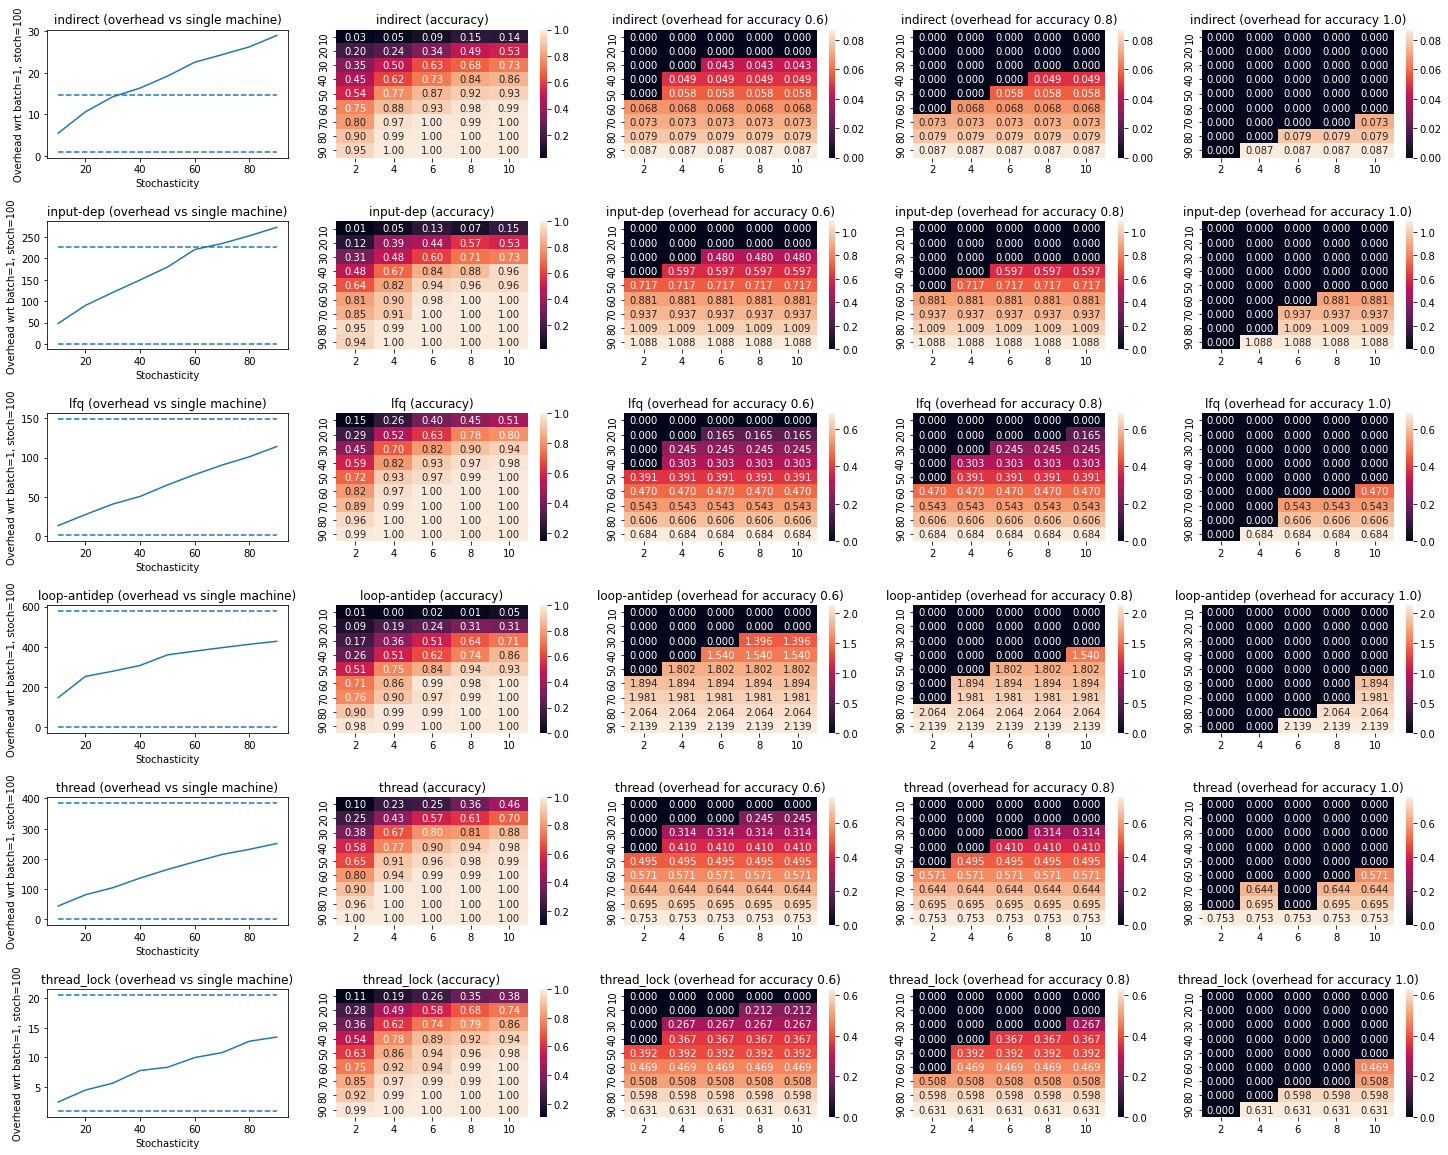

In [15]:
import matplotlib.pyplot as plt


target_accuracies = np.array([60, 80, 100]) / 100

fig, axs = plt.subplots(testname_size, 2 + target_accuracies.size, figsize=(25, 20))
plt.subplots_adjust(hspace=0.5)


i = 0
for testname, result in complete_run_dict.items():
    print(f"Started \"{testname}\"")
    overhead = result[:,:,0]
    print(overhead)
    overhead_mean = np.mean(overhead, axis=1)
    axs[i][0].plot(stoch_range, overhead_mean / noinst_dict[testname])
    axs[i][0].hlines(y=baseline_dict[testname]/noinst_dict[testname], xmin=stoch_range[0], xmax=stoch_range[-1], linestyles='dashed')
    axs[i][0].hlines(y=1.0, xmin=stoch_range[0], xmax=stoch_range[-1], linestyles='dashed')
    axs[i][0].set_title(testname + ' (overhead vs single machine)')
    axs[i][0].set_xlabel('Stochasticity')
    axs[i][0].set_ylabel('Overhead wrt batch=1, stoch=100')
    
    accuracy = result[:,:,1] / 100
    sns.heatmap(accuracy, annot=True, fmt='.2f',
               xticklabels=batch_range,
               yticklabels=stoch_range,
               ax=axs[i][1])
    axs[i][1].set_title(testname + ' (accuracy)')

    for j, target_accuracy in enumerate(target_accuracies):
        max_matrix = (accuracy >= target_accuracy) * np.expand_dims(overhead_mean, axis=1) + (500*(accuracy>1.0))
        #optimize_matrix = (accuracy**3) / np.expand_dims(overhead_mean, axis=1)**2
        sns.heatmap(max_matrix, annot=True, fmt='.3f',
                   xticklabels=batch_range,
                   yticklabels=stoch_range,
                   ax=axs[i][2+j])
        axs[i][2+j].set_title(testname + f" (overhead for accuracy {target_accuracy})")
    
    
    i += 1


In [299]:
fig.savefig('ht_m.jpg')

In [259]:
plt.savefig('ht.png')

<Figure size 432x432 with 0 Axes>

Folowing runs for results in results_naive_balanced

In [68]:
# Parse results

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as it
import re
from pathlib import Path

def mean(l):
    return sum(l) / len(l)

def parse_run_file(dpath, run_dict, run_idx, batch_idx, ty):
    with open(dpath, 'r') as f:
        lines = list(f.readlines())
        
    header = re.compile(r'--> Test (\S+) <--')
    time = re.compile(r'Time:\s*(.*)')
        
    run_results = [lines[i::2] for i in range(2)]
    compiler = [(header, str), (time, float)]
    full_results = [[compiler[i][1](compiler[i][0].match(elems).group(1)) \
                         for elems in run_key] for i, run_key in enumerate(run_results)]
    full_results[0] = [Path(x).name.split('.')[0] for x in full_results[0]]
    full_results = list(zip(*full_results))
    for tup in full_results:
        run_dict[tup[0]][ty][run_idx][batch_idx] = np.array(tup[1:])
    

    
def parse_batch_file(dpath, run_dict, run_idx, batch_idx):
    with open(dpath, 'r') as f:
        lines = list(f.readlines())
        
    header = re.compile(r'--> Batch: (\S+) <--')
    max_time = re.compile(r'Max Time:\s*(.*)')
    accuracy = re.compile(r'Accuracy:\s*(.*)')
    
    run_results = [lines[i::3] for i in range(3)]

    compiler = [(header, str), (max_time, float), (accuracy, float)]
    full_results = [[compiler[i][1](compiler[i][0].match(elems).group(1)) \
                         for elems in run_key] for i, run_key in enumerate(run_results)]
    
    full_results = list(zip(*full_results))
    for tup in full_results:
        run_dict[tup[0]]["batchinst"][run_idx][batch_idx] = np.array(tup[1:])

    
    
results_dir = Path('results_naive_balanced')

batch_inc = 2
batch_start = 2
batch_range = np.arange(batch_start, 10, batch_inc)
num_runs = 20

testnames = [p.stem for p in Path('tests').glob("*.c")]
run_dict = {key: { "noinst" : np.ones([num_runs, batch_range.size]), \
                            "allinst": np.ones([num_runs, batch_range.size]), \
                            "batchinst": np.ones([num_runs, batch_range.size, 2]) \
                          } for key in testnames }

for batch_size in batch_range:
    for run_no in range(1, num_runs+1):
        parse_batch_file(results_dir / f"run_{run_no}_{batch_size}.res", run_dict, \
                         run_no-1, (batch_size - batch_start) // batch_inc )
        parse_run_file(results_dir / f"allinst_run_{run_no}_{batch_size}.res", run_dict, \
                         run_no-1, (batch_size - batch_start) // batch_inc, "allinst" )
        parse_run_file(results_dir / f"noinst_run_{run_no}_{batch_size}.res", run_dict, \
                         run_no-1, (batch_size - batch_start) // batch_inc, "noinst" )

#for k, secs in run_dict.items():
#    for ty, res in secs.items():
#        run_dict[k][ty] = np.mean(res, axis=0)


In [70]:
run_dict

{'comp-opt-bug': {'noinst': array([[0.011, 0.012, 0.011, 0.011],
         [0.012, 0.012, 0.012, 0.013],
         [0.013, 0.012, 0.012, 0.013],
         [0.012, 0.013, 0.013, 0.012],
         [0.012, 0.012, 0.012, 0.012],
         [0.012, 0.012, 0.012, 0.012],
         [0.012, 0.013, 0.013, 0.012],
         [0.013, 0.012, 0.012, 0.013],
         [0.012, 0.013, 0.012, 0.013],
         [0.012, 0.012, 0.012, 0.012],
         [0.012, 0.012, 0.013, 0.012],
         [0.012, 0.012, 0.013, 0.013],
         [0.012, 0.012, 0.013, 0.012],
         [0.014, 0.012, 0.013, 0.012],
         [0.012, 0.012, 0.012, 0.012],
         [0.013, 0.012, 0.012, 0.012],
         [0.013, 0.012, 0.012, 0.012],
         [0.012, 0.012, 0.013, 0.012],
         [0.013, 0.012, 0.012, 0.013],
         [0.012, 0.012, 0.015, 0.012]]),
  'allinst': array([[3.5  , 3.738, 4.019, 4.082],
         [4.407, 4.882, 4.705, 4.547],
         [4.637, 4.377, 4.458, 4.649],
         [4.418, 4.383, 4.756, 4.405],
         [4.695, 4.696, 4

Started "comp-opt-bug"
Started "comp-unopt-bug"
Started "indirect"
Started "thread"
Started "loop-antidep"
Started "thread_lock"
Started "lfq"
Started "input-dep"


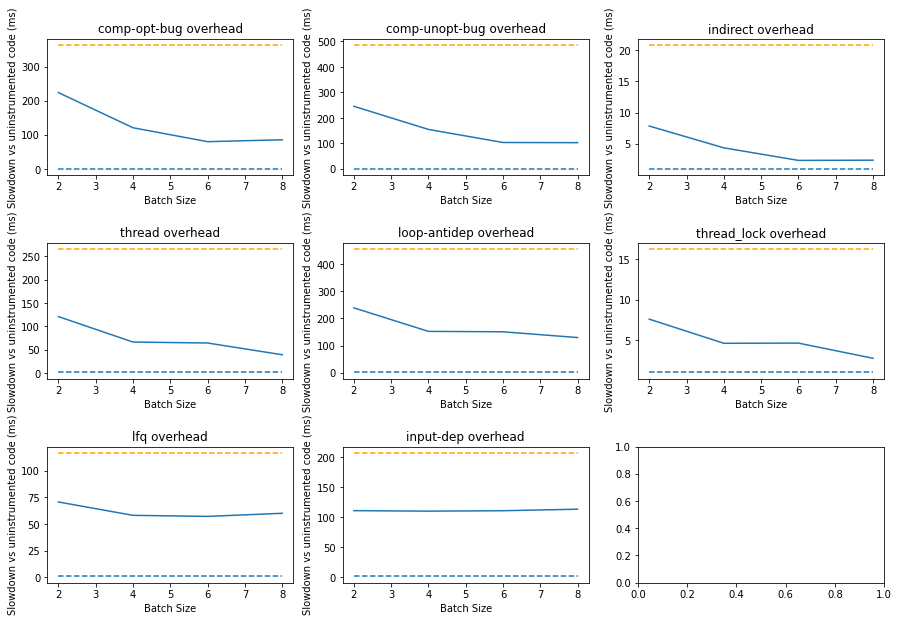

In [77]:
import matplotlib.pyplot as plt
import math

fig, axs = plt.subplots(math.ceil(len(testnames)/3), 3, figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

i = 0
for testname, results in run_dict.items():
    print(f"Started \"{testname}\"")
    batch_overhead = np.mean(results["batchinst"][:,:,0] / results["noinst"], axis=0)
    allinst_avg_overhead = np.mean(results["allinst"] / results["noinst"])
    axs[i//3][i%3].plot(batch_range, batch_overhead)
    
    axs[i//3][i%3].hlines(y=allinst_avg_overhead, xmin=batch_range[0], xmax=batch_range[-1], linestyles='dashed', color='orange')
    axs[i//3][i%3].hlines(y=1.0, xmin=batch_range[0], xmax=batch_range[-1], linestyles='dashed')
    axs[i//3][i%3].set_title(testname + ' overhead')
    axs[i//3][i%3].set_xlabel('Batch Size')
    axs[i//3][i%3].set_ylabel('Slowdown')
    
    i += 1

In [78]:
fig.savefig('naive_balance.jpg')